# Tutorial on How To Use The *mqhandler* Package

In this tutorial, we will show how to use the different functionalities of the mqhandler. The mqhandler package comprises 4 functionalities:
- filter protein IDs
- remap gene names
- reduce gene names
- map orthologs

In this tutorial, we will first load the data into a pandas dataframe. Then, the protein ids will be filtered, the gene names remapped and reduced to gene names having an Ensembl ID. Finally, we will map the gene names to human orthologs.

## Installation

In [ ]:
# Install mqhandler python package
import sys
!{sys.executable} -m pip install mqhandler==0.0.20

In [ ]:
from importlib.metadata import version
version('mqhandler')

## 1. Load Data

In order to use the mqhandler functionalities, you need to load your data into a pandas dataframe. This could be a MaxQuant proteinGroups.txt output, a single column with protein IDs or any other matrix with a column of ids/gene names.

In this tutorial, we will use proteomics data processed with MaxQuant.

#### 1.1 Imports

In [ ]:
import pandas as pd
from mqhandler.mq_utils.runner_utils import find_delimiter

#### 1.2 Specify File Path

In [ ]:
file = "<file_path>"

#### 1.3 Load Your Data

In [ ]:
data = pd.read_table(file, sep=find_delimiter(file)).fillna("")
data.head(5)

## 2. Filter Protein IDs

For a protein assignment using MaxQuant, Fasta files are required. Since MaxQuant can also be used to run several data collectively, it can also happen that results are provided with protein IDs of several organisms. This method makes it possible to check the protein IDs for their organism by directly accessing the Uniprot database, and to remove incorrectly assigned IDs. Additionally, decoy (REV_) and contaminants (CON_) IDs and/or unreviewed protein IDs can be removed.


First you need to import the method from the mqhandler package. Following the specification of a few parameters, the method can be called. The selected protein column is filtered and a new dataframe is returned. 

One might be interested to know how many IDs were filtered out, in total and per row. Therefore, with this call, you can generate 2 data frames that display this information as a table.

In addition to the information as a table, it can also be displayed directly as plots with a simple call.

#### 2.1 Imports

In [ ]:
from mqhandler import filter_ids as fi

#### 2.2 Set Preferences

In [ ]:
# mandatory
protein_column = "Protein IDs" # Name of column with protein IDs

# optional
organism = "rat" # Specify organism the IDs should match to
rev_con = False # Bool to indicate if protein IDs from decoy (REV__) and contaminants (CON__) should be kept
reviewed = False # Bool to indicate if newly retrieved protein IDS should be reduced to reviewed ones
keep_empty = False # Bool to indicate if empty ID cells should be kept or deleted
res_column = None # Name of column for filer protein IDs results. If None, the protein_column will be overridden

#### 2.2 Run filter_protein_ids

In [ ]:
fi_data, fi_log_dict = fi.filter_protein_ids(data = data, protein_column = protein_column, 
                                             organism = organism, rev_con = rev_con, keep_empty = keep_empty, 
                                             reviewed = reviewed, res_column = res_column)
fi_data.head(5)

#### 2.3 Inspect Logging

In [ ]:
from mqhandler.mq_utils import plotting as pt
out_dir = "<out_dir>"
pt.create_overview_plot(fi_log_dict["Overview_Log"], out_dir = out_dir)

In [ ]:
pt.create_filter_detailed_plot(fi_log_dict["Detailed_Log"], organism = organism, 
                               reviewed = reviewed, decoy = rev_con, out_dir = out_dir)

## 3. Remap Gene Names

Besides protein IDs, gene names are also taken out of the respective Fasta files and mapped. These are needed for easier naming in plots and in analytical procedures such as enrichment analysis. Unfortunately, Fasta files are not always complete in terms of gene names.

This method makes it possible to retrieve the assigned gene names based on the protein IDs with direct access to the Uniprot database and to fill the empty entries in the user file or even replace existing entries. There are multiple possible modes for which names should be taken.


Again, you need to import the mqhandler's function and specify some preferences before running the method. The selected gene name column is remapped based on the protein ids column that has been specified. A dataframe including the remapped gene name column and all other columns of the original data is returned.

Here, too, it is possible to subsequently obtain information on how many gene names were found for how many rows. This can also be displayed as a plot with a simple call.

In this tutorial, we will call the remap gene names function on the data that has already been processed using the filter IDs method. 

#### 3.1 Imports

In [ ]:
from mqhandler import remap_genenames as rmg

#### 3.2 Set Preferences

In [ ]:
# mandatory
mode = "uniprot_primary" # Mode of refilling. See below for more infos.
protein_column = "Protein IDs" # Name of column with protein IDs

# optional
gene_column = "Gene names" # Name of column with gene names
skip_filled = False # Bool to indicate if already filled gene names should be skipped
organism = "rat" # Specify organism the IDs should match to
fasta = None # Path of Fasta file when mode all or fasta
keep_empty = False # Bool to indicate if empty gene names cells should be kept or deleted
res_column = None # Name of column for remap gene names results. If None, the gene_column will be overridden

**Modes of refilling:**
- all : Use primarly fasta infos and additionally uniprot infos.
- fasta: Use information extracted from fasta headers.
- uniprot: Use mapping information from uniprot and use all gene names.
- uniprot_primary: Use mapping information from uniprot and only all primary gene names.
- uniprot_one: Use mapping information from uniprot and only use most frequent single gene name.

#### 3.3 Run remap_genenames

In [ ]:
rmg_data, rmg_log_dict = rmg.remap_genenames(data = fi_data, mode=mode, protein_column = protein_column,
                                            gene_column = gene_column, skip_filled = skip_filled, organism = organism, 
                                             fasta = fasta, keep_empty = keep_empty, res_column = res_column)
rmg_data.head(5)

## 4. Reduce Gene Names

A well-known problem with gene symbols is that they are not unique and slight changes in spelling can lead to problems. Often there are different gene symbols for the same gene in UniProt. Depending on which protein IDs you used to get the gene symbol, you can get multiple gene symbols for the same gene by using the previous remap function.

This method makes it possible to reduce the gene symbols to a common gene symbol using different features and databases, thus preventing redundancy. There are multiple possible modes for which names should be taken. 

Again, you need to import the mqhandler's function and specify some preferences before running the method. A dataframe including the reduced gene name column and all other columns of the original data is returned.

Here, too, it is possible to subsequently obtain information on how many gene names were reduced for how many rows. This can also be displayed as a plot with a simple call.

In this tutorial, we will call the reduce gene names function on the data that has already been processed using the filter IDs and remap gene names method. 

#### 4.1 Imports

In [1]:
import sys
import pandas as pd
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import reduce_genenames as rdg

#### 4.2 Set Preferences

In [2]:
rmg_data = pd.read_csv("../MaxQuantHandler-R/test.csv")

In [3]:
# mandatory
mode = "ensembl" # Mode of reduction. See below for more infos-
gene_column = "Remapped Gene Names" # Name of column with gene names
organism = "human" # Specify organism the IDs should match to

# optional
res_column = False # Name of column of reduced gene names results. If None, the gene_column will be overridden
keep_empty = False # Bool to indicate if empty reduced gene names cells should be kept or deleted
HGNC_mode = None # Mode on how to reduce the gene names using HGNC (mostfrequent, all)

**Modes of reduction:**
- ensembl : Use gProfiler to reduce gene names to those having a Ensembl ID
- HGNC: Use HGNC database to reduce gene names to those having an entry in HGNC (only for human)
- mygeneinfo: Use mygeneinfo database to reduce gene names to those having an entry in mygeneinfo
- enrichment: Use gProfiler to reduce gene names to those having a functional annotation

#### 4.3 Run reduce_genenames

In [4]:
rdg_data, rdg_log_dict = rdg.reduce_genenames(data = rmg_data, mode = mode, gene_column = gene_column, 
                                              organism = organism, res_column = res_column, keep_empty = keep_empty,
                                             HGNC_mode = HGNC_mode)
rdg_data.head(5)

/home/kikky/Projects/symbod/handler/MaxQuantHandler/mq_utils/mapping_handler.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapping.loc[:, "Organism"] = organism


,Unnamed: 0,Protein IDs,Filtered Protein IDs,Remapped Gene Names,False
0,1,P08123,P08123,COL1A2,COL1A2
1,2,A0A0G2JIW1;V9GZ37;P0DMV9;P0DMV8,P0DMV8;V9GZ37;A0A0G2JIW1;P0DMV9,HSPA1A;HSPA1B,HSPA1B;HSPA1A
2,3,F8WCH0;P63267;F8WB63;F6UVQ4;C9JFL5;F6QUT6;P627...,F6QUT6;F8WB63;B8ZZJ2;P63267;F8WCH0;P62736;C9JF...,ACTA2;ACTG2,ACTA2;ACTG2
3,4,A0A3B3ITK0;Q5RI53;P35442,A0A3B3ITK0;P35442;Q5RI53,THBS2,THBS2
4,5,B1ALD9,B1ALD9,POSTN,POSTN


#### 4.4 Inspect Logging

In [ ]:
pt.create_overview_plot(rdg_log_dict["Overview_Log"], out_dir = out_dir)

In [ ]:
pt.create_reduced_detailed_plot(rdg_log_dict["Detailed_Log"], out_dir = out_dir)

## 5. Map Orthologs

Suppose you want to compare data between organisms, for example if you want to do a review across several species, you come across a known problem. Gene names differ between species, making it necessary to map all IDs to a selected organism through an ortholog mapping.

Using the commonly used gProfiler, this method simply maps the gene names from the current organism to the target organism.

Again, you need to import the mqhandler's function and specify some preferences before running the method. The selected gene name column is mapped to its orthologs based on target organism that has been specified. A dataframe including the mapped ortholog gene names and all other columns of the original data is returned.

Unfortunately, depending on the original and target organism, there are more or less cases where no orthologous gene could be found. For a simplified overview of how many cases this was the case, this method can be used to obtain this information.

As with the previous tasks, the log information can be displayed in plots.

#### 5.1 Imports

In [1]:
import sys
import pandas as pd
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import map_orthologs as mo

In [2]:
rdg_data = pd.read_csv("../MaxQuantHandler-R/test.csv")
rdg_data

,Unnamed: 0,Gene Names
0,1,Ptbp1
1,2,Col24a1
2,3,Kidins220
3,4,Ccl8
4,5,Cox8a
...,...,...
603,604,Ints10
604,605,Maea
605,606,Alcam
606,607,Eif2d


#### 5.2 Set Preferences

In [3]:
# mandatory
gene_column = "Gene Names" # Name of column with gene names
source_organism = "mouse" # Specify organism the IDs match to
tar_organism = "human" # Specify organism the IDs should me mapped to

# optional
keep_empty = False # Bool to indicate if empty ortholog gene names cells should be kept or deleted
res_column = None # Name of column of orthologs gene names results. If None, the gene_column will be overridden

#### 5.3 Run map_orthologs

In [4]:
mo_data, mo_log_dict = mo.map_orthologs(data = rdg_data, gene_column = gene_column, organism = source_organism,
                                           tar_organism = tar_organism, keep_empty = keep_empty, 
                                            res_column = res_column)
mo_log_dict

    source_symbol source_organism                ensg    ortholog_ensg  \
0            Arf3           mouse  ENSMUSG00000051853  ENSG00000134287   
1             Hal           mouse  ENSMUSG00000020017  ENSG00000084110   
2            Spp2           mouse  ENSMUSG00000026295  ENSG00000072080   
3            Cbr2           mouse  ENSMUSG00000025150              N/A   
4           Sf3b6           mouse  ENSMUSG00000037361  ENSG00000115128   
..            ...             ...                 ...              ...   
624          Ppat           mouse  ENSMUSG00000029246  ENSG00000128059   
625         Dpy30           mouse  ENSMUSG00000024067  ENSG00000162961   
626        Wfdc17           mouse  ENSMUSG00000069792              N/A   
627          Nfs1           mouse  ENSMUSG00000027618  ENSG00000244005   
628        Hsd3b7           mouse  ENSMUSG00000042289  ENSG00000099377   

    target_symbol target_organism  \
0            ARF3           human   
1             HAL           human   


{'Overview_Log':       Gene Names Ortholog Gene Names Removed Gene Names  Nr Gene Names  \
 0        [Ptbp1]             [PTBP1]                 []              1   
 1      [Col24a1]                  []          [Col24a1]              1   
 2    [Kidins220]         [KIDINS220]                 []              1   
 3         [Ccl8]              [CCL8]                 []              1   
 4        [Cox8a]             [COX8A]                 []              1   
 ..           ...                 ...                ...            ...   
 603     [Ints10]            [INTS10]                 []              1   
 604       [Maea]              [MAEA]                 []              1   
 605      [Alcam]             [ALCAM]                 []              1   
 606      [Eif2d]             [EIF2D]                 []              1   
 607     [Itga11]            [ITGA11]                 []              1   
 
      Nr Ortholog Gene Names  Nr Removed Gene Names  
 0                         1

In [6]:
";".join(set())

''

In [7]:
""

''

#### 5.4 Inspect Logging

In [ ]:
pt.create_overview_plot(mo_log_dict["Overview_Log"], out_dir = out_dir)

In [ ]:
pt.create_ortholog_detailed_plot(mo_log_dict["Detailed_Log"], organism = organism, out_dir = out_dir)

#  Test>

In [1]:
import sys
import pandas as pd
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import intersection_analysis as ia

In [2]:
files = [
    pd.read_csv("../Paper/data/K_g.txt", names=["gene"]),
    pd.read_csv("../Paper/data/L_g.txt", names=["gene"]),
    pd.read_csv("../Paper/data/R_g.txt", names=["gene"]),
    pd.read_csv("../Paper/data/O_g.txt", names=["gene"]),
    
]
data = ia.load_multi_files(files=files, columns=None)

In [3]:
intersections = ia.count_intersection(data, threshold=2)

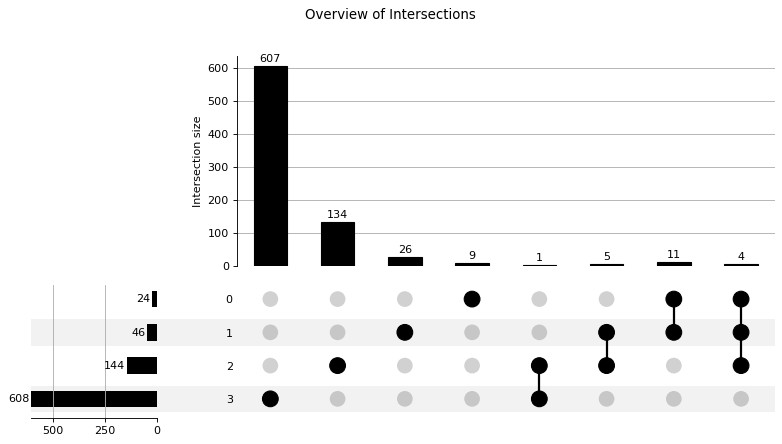

In [4]:
ia.plot_intersections(data, out_dir="", file_type="png")

In [5]:
import requests

In [6]:
url = 'https://api.drugst.one/create_network'
myobj =  {"network":{'nodes': [{"id":gene, "group":"gene"} for gene in intersections["ID"]]}}

x = requests.post(url, json = myobj)

In [7]:
"https://drugst.one?id="+x.json()

'https://drugst.one?id=7d95dc645f0f4a42a7f7b107e65537b9'